In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

# Lineare Basisfunktionsmodelle

Dieses Notebook illustriert lineare Basisfunktionsmodelle. Durch das Experiementieren mit dem Code können Sie folgende Aspekte dieser Modelle ausprobieren:

* Wie unterschiedliche Basisfunktionen unterschiedliche Vorhersagen ergeben
* Wie komplexe Modelle statt das Muster zu erklären auch das Rausche miterklären
* Den Effekt von Regularisieren
* Vorhersagen mit Unsicherheit durch das definieren von Prior Verteilungen auf den Parametern. 



### Synthetische Daten 

Wir generieren uns synthetische Daten, an die wir die Modelle anpassen. Die datengenerierende Funktion ist $f(x) = sin(2 \pi x) + 1$. Auf die so generierten Daten wird normalverteilem Rauschen $N(0, \beta)$ addiert.

In [2]:
np.random.seed(42)
beta = 0.2

xs = np.array([-1.0, -0.9, 0.85, -0.8, -0.75, -0.1, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0])
def true_fun(xs): 
    return np.sin(2 * math.pi * xs) + 1

ys = true_fun(xs) + stats.norm(0, beta).rvs(len(xs))

(-2.0, 4.0)

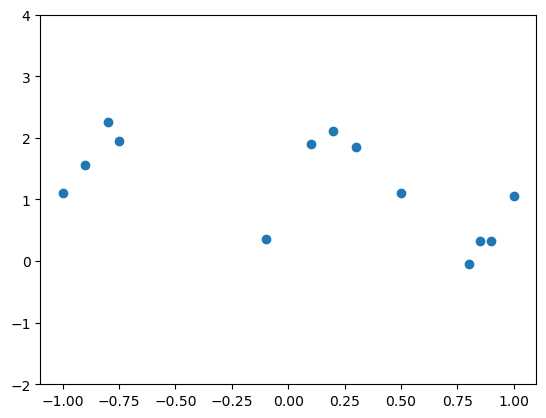

In [3]:
plt.plot(xs, ys, 'o')
plt.ylim([-2,4])


## Lineare Basisfunktionsmodelle 

Die folgende Funktion nimmt eine Liste von Basisfunktionen, sowie die Daten entgegen, 
und berechnet die Parameter des Modells. Zur Berechnung werden einfach die Normalgleichungen gelöst. 

In [4]:

def solve_regression(basis_functions, xs, ys):
    """ takes a list of basis_functions as well as the training data (xs, ys) and solves the 
        corresponding regression problem using the normal equation """
    m = len(basis_functions)
    
    # Matrix containing the basis functions evaluated at the input points
    Phi = np.zeros((len(xs), m))  
    for j in range(0, m):
        Phi[:,j] = basis_functions[j](xs)
        
    # small additional regularization term to improve numerical stability
    reg = 1e-10 * np.eye(len(basis_functions))
    w = np.linalg.inv(Phi.transpose() @ Phi + reg) @ Phi.transpose()

    return w @ ys

Die folgende Funktion wird benutzt um die Lösung zu visualisieren. 

In [33]:
def plot_solution(w, basis_functions, xs, ys, show_basis = True, show_gt = True):
    """
    plots the basis function and the solutions for the (fitted) parameters w.
    xs and ys contain the data. 
    The parameter show_gt and show_basis determine whether the ground truth 
    and basis functions are plotted. 
    """
    # plot in the interval -1, 1
    x_values = np.linspace(-1, 1, 200)
    y_values = np.zeros(len(xs))
    
    # Compute the solution
    Phi = np.zeros((len(x_values), len(basis_functions)))
    for j in range(0, len(basis_functions)):
        Phi[:,j] = basis_functions[j](x_values)
    y_values = Phi @ w
    
    # Plot the best prediction
    plt.plot(xs, ys, 'o')    
    plt.plot(x_values, y_values, 'k', label="predicted")

    
    # Plot the basis fucntions
    if show_basis:
        for j in range(0, len(basis_functions)):
            plt.plot(x_values, basis_functions[j](x_values) * w[j], ':', color="grey")
  
    if show_gt:
        plt.plot(x_values,true_fun(x_values), '--r', label="ground truth")
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.ylim([-2, 4])
    plt.legend()

Als erstes definieren wir als Basisfunktionen Polynome bis Grad $m$.

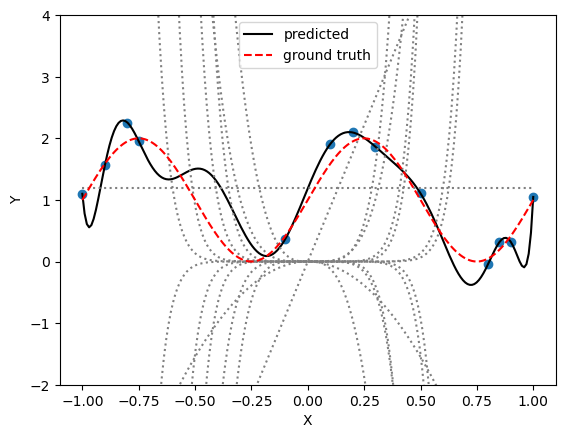

In [35]:
m = 13
basis_functions = [lambda x, i=i : np.power(x, i) for i in list(range(0,m+1))]
ws = solve_regression(basis_functions, xs, ys)
plot_solution(ws, basis_functions, xs, ys, show_gt = True)

Als nächstes definieren wir radiale Basisfunktionen der Breite $s$ und passen das daraus resultierende Modell an die Daten an. 
Wenn wir $s$ unterschiedliche wählen bekommen wir sehr unterschiedliche Lösungen.

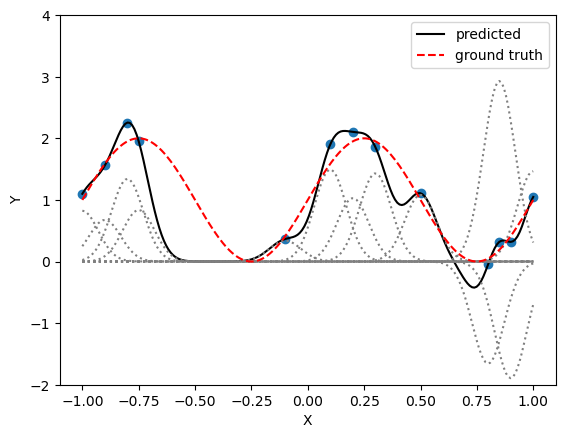

In [68]:
s = 0.01
basis_functions = [lambda x, mu=mu : np.exp(-np.power(x-mu, 2)/s) for mu in xs ]
ws = solve_regression(basis_functions, xs, ys)
plot_solution(ws, basis_functions, xs, ys, show_gt = True)

Die Daten werden in diesem Fall perfekt interpoliert. Da die Daten auch verrauscht sind, passt sich das Modell also auch an das Rauschen an. Eine einfache Möglichkeit dem Abhilfe zu schaffen ist Ridge regression. 

### Einfache Lösungen: Ridge regression

Um einfache Lösungen zu forcieren, die auch bei flexiblen Modellen (vielen Basisfunktionen) das Rauschen nicht mitlernen, bestrafen wir Lösungen bei denen die Parameter gross sind. Wir lösen also $min_w \sum_{i=0}^n (f(x_i,w)-y_i) + \alpha \lVert w \rVert^2 $

In [69]:
  
def solve_regression_ridge(basis_functions, xs, ys, alpha):
    """ takes a list of basis_functions as well as the training data (xs, ys) and solves the 
        corresponding regression problem using least squares regression """
    m = len(basis_functions)
    Phi = np.zeros((len(xs), m))
    for j in range(0, m):
        Phi[:,j] = basis_functions[j](xs)
    w = np.linalg.inv(Phi.transpose() @ Phi + alpha * np.eye(len(basis_functions))) @ Phi.transpose()

    return w @ ys

Je grösser wir den Regularisierungsparameter $\alpha$ wählen, desto mehr werden die Basisfunktionen gedämpft und die Lösung wird "glatter".

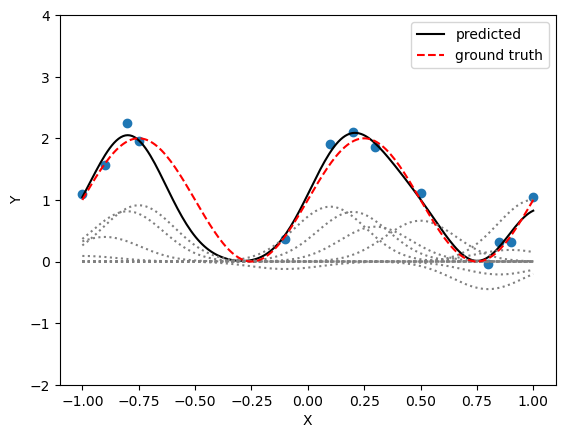

In [71]:
s = 0.05
alpha = 0.1
basis_functions = [lambda x, mu=mu : np.exp(-np.power(x-mu, 2)/s) for mu in xs ]
ws = solve_regression_ridge(basis_functions, xs, ys, alpha)
plot_solution(ws, basis_functions, xs, ys, show_gt = True)

### Bayesian regression

Bayes'sche lineare Regression bietet noch eine andere, probabilistische, Möglichkeit, Annahmen an die Daten zu definieren. 
Namlich wird angenommen, dass die Parameter normalverteilt mit Mittelwert 0 sind: $w_i \sim N(0, \alpha)$.
Der nachfolgende Code enthält eine Implementation für die Bayesianische lineare regression. 
Wir gehen nicht auf die Implementationsdetails ein. 

In [72]:
def solve_regression_bayesian(basis_functions, xs, ys, alpha, sigma):
    """ takes a list of basis_functions, the training data (xs, ys) and solves the 
        corresponding bayes regression problem using a N(0, alpha^2) prior on w and 
        an assumed noise on the data of N(0, sigma^2)"""
    m = len(basis_functions)
    Phi = np.zeros((len(xs), m))
    for j in range(0, m):
        Phi[:,j] = basis_functions[j](xs)

        
    S0 = np.eye(len(basis_functions))
    prec_mat = (1.0 / alpha) * S0 + 1.0/noise_var * Phi.transpose() @ Phi
    cov = np.linalg.inv(prec_mat)
    mean_vec = 1.0/noise_var * cov@(Phi.transpose() @ ys)
 
    return stats.multivariate_normal(mean_vec, cov)

Wir müssen die Visualisierungsmethode noch etwas anpassen, da die Parameter jetzt über eine Verteilung gegeben sind. 

In [73]:
def plot_solution_bayes(w_dist, basis_functions, xs, ys, num_samples):
    """ plots n samples from the solution. w_dist is the posterior 
        distribution over the parameters w
    """
    x_values = np.linspace(-1, 1, 200)

    Phi = np.zeros((len(x_values), len(basis_functions)))
    for j in range(0, len(basis_functions)):
        Phi[:,j] = basis_functions[j](x_values)

    plt.plot(xs, ys, 'o')    
    
    y_values = Phi @ w_dist.mean
    plt.plot(x_values, y_values, 'k', label="Mittelwert (beste Vorhersage)")
    for i in range(0, num_samples):
        w = w_dist.rvs()
        y_values = Phi @ w
        plt.plot(x_values, y_values, 'y--')

    plt.ylim([-2, 4])
    plt.legend()

Der folgende Aufruf zeigt, dass wir mit der Bayesianischen linearen Regression nicht nur eine beste Lösung erhalten, sondern eine Verteilung über mögliche Lösungen. Wir zeigen einige Samples davon. Wenn wir die Varianz der Verteilung über die Parameter erhöhen, oder mehr Rauschen annehmen, erhalten wir eine höhere Unsicherheit in der Lösung.  

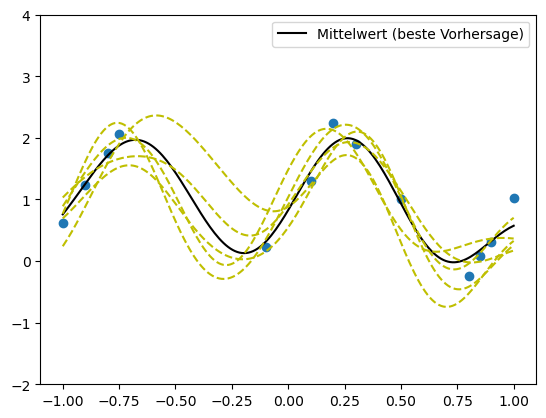

In [74]:
xs = np.array([-1.0, -0.9, 0.85, -0.8, -0.75, -0.1, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0])
ys = true_fun(xs) + stats.norm(0, beta).rvs(len(xs))

s = 0.1
prior_var = 1  # Varianz der Prior Verteilung über die Parameter
noise_var = beta  # Varianz des Rauschens auf den Daten 
basis_functions = [lambda x, mu=mu : np.exp(-np.power(x-mu, 2)/s) for mu in np.linspace(-1, 1, 20) ]
w_dist = solve_regression_bayesian(basis_functions, xs, ys, prior_var, noise_var)
plot_solution_bayes(w_dist, basis_functions, xs, ys, 5)